<a href="https://colab.research.google.com/github/QuratulAin20/Machine-Learning/blob/main/Kindle_Review_Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-kindle-book-review-for-sentiment-analysis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1569305%2F2583418%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240926%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240926T154805Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6b86d5f7639e44f4bfbb4b8eb051b65213f56254a39a91ceda0228fb5c5273eeb212710ec032145a1f0a54e66432d8d17c9b59dfbdd7383c353c3eb8078721d66d809f3f69a1daf856c8810dd194b1d799822062c2da570676c78f009628f1149749a30b8ae8b9a9e5ffdf10f1a593dc128b5205967e0b1a98d6f89856f9faf359f04772ddf4c4987cff41690eb7e56604a1ba1c7f483753d34a770225b73983df039cb6433e349ba9862a16db3d2ae2e5bec15ea684c125f336e5210829538f025b5bef8bd6f11f03ccf228e69a16d9d75132a85cb2eb939c58bef8eee4c2ea6b3cb8744239d35c40d4a330627913933138399ca17fb222ac566f8317602327'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6686485 bytes downloaded
Downloaded and uncompressed: amazon-kindle-book-review-for-sentiment-analysis
Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv("/kaggle/input/amazon-kindle-book-review-for-sentiment-analysis/preprocessed_kindle_review .csv")

In [ ]:
df.head()

,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!


In [ ]:
df.shape

(12000, 4)

In [4]:
data = df.iloc[:,1:3]

In [ ]:
data

,rating,reviewText
0,5,This book was the very first bookmobile book I...
1,1,"When I read the description for this book, I c..."
2,5,I just had to edit this review. This book is a...
3,5,I don't normally buy 'mystery' novels because ...
4,5,"This isn't the kind of book I normally read, a..."
...,...,...
11995,2,Had to read certain passages twice--typos. Wi...
11996,3,Not what i expected. yet a very interesting bo...
11997,5,Dragon Knights is a world where Knights ride d...
11998,4,"Since this story is very short, it's hard to s..."


In [ ]:
data.isnull().sum()

rating        0
reviewText    0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rating      12000 non-null  int64 
 1   reviewText  12000 non-null  object
dtypes: int64(1), object(1)
memory usage: 187.6+ KB


In [ ]:
data.duplicated().sum()

0

In [ ]:
data['rating'].unique()

array([5, 1, 4, 3, 2])

In [ ]:
# checking whether the data is imbalanced
counts = data['rating'].value_counts()

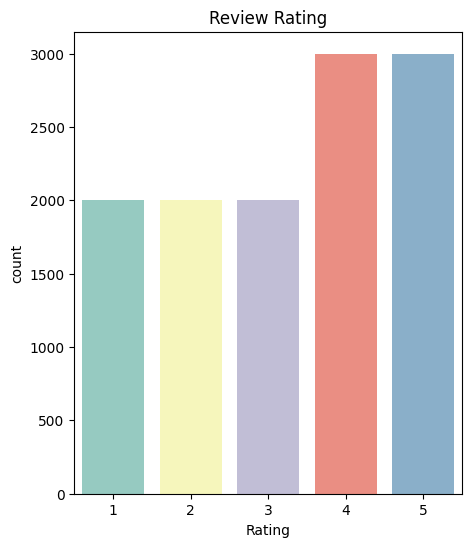

In [ ]:
plt.figure(figsize=(5,6))
sns.barplot(x=counts.index , y=counts.values, palette='Set3')
plt.title('Review Rating')
plt.xlabel("Rating")
plt.ylabel("count")
plt.show()

## Preprocessing

In [5]:
data['rating']=data['rating'].apply(lambda x:0 if x<3 else 1)

In [6]:
data

,rating,reviewText
0,1,This book was the very first bookmobile book I...
1,0,"When I read the description for this book, I c..."
2,1,I just had to edit this review. This book is a...
3,1,I don't normally buy 'mystery' novels because ...
4,1,"This isn't the kind of book I normally read, a..."
...,...,...
11995,0,Had to read certain passages twice--typos. Wi...
11996,1,Not what i expected. yet a very interesting bo...
11997,1,Dragon Knights is a world where Knights ride d...
11998,1,"Since this story is very short, it's hard to s..."


In [ ]:
data['rating'].unique()

array([1, 0])

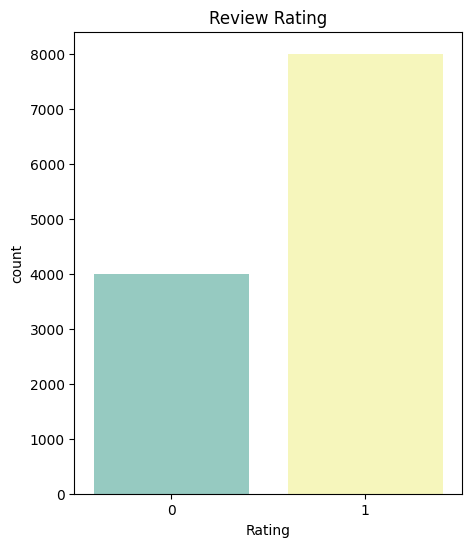

In [ ]:
counts=data['rating'].value_counts()
plt.figure(figsize=(5,6))
sns.barplot(x=counts.index , y=counts.values, palette='Set3')
plt.title('Review Rating')
plt.xlabel("Rating")
plt.ylabel("count")
plt.show()

In [7]:
# lower case
data['reviewText'] = data['reviewText'].str.lower()

In [8]:
#data['reviewText'] = data['reviewText'].str.lower
# removing special character
data['reviewText']= data['reviewText'].apply(lambda x:re.sub('[^a-z A-Z 0-9]+',"",x))

#Removing url tags
data['reviewText']= data['reviewText'].apply(lambda x:re.sub(r'[\b(http|https|ftp)://?:\\/\\/(?:www\\.)\\b(?:()@:%_\\+.~#?&\\/=*)$]', '',str(x)))

# Removing html tags
data['reviewText']=data['reviewText'].apply(lambda x:BeautifulSoup(x, 'lxml').get_text())

# Removing additional spaces
data['reviewText']=data['reviewText'].apply(lambda x: " ".join(x.split()))

In [ ]:
data.head()

,rating,reviewText
0,1,i ook a e very ir ookmoile ook i oug en i a in...
1,0,en i read e decriion or i ook i couldn ai o re...
2,1,i ju ad o edi i revie i ook i an i elieve i go...
3,1,i don normally uy myery novel ecaue i ju don l...
4,1,i in e kind o ook i normally read aloug i ry n...


# Lemmatization

In [9]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [10]:
lem = WordNetLemmatizer()

In [12]:
def lem_word(text):
    return " ".join([lem.lemmatize(word) for word in text.split()])

In [13]:
data['reviewText'] = data['reviewText'].apply(lambda x:lem_word(x))

# Model Training

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data['reviewText'],data['rating'],test_size=0.2,random_state=42)

# Vectorization

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer()
X_train_bow = bow.fit_transform(X_train).toarray()
X_test_bow = bow.transform(X_test).toarray()
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [17]:
# Train a Naive Bayes classifier
model_bow = MultinomialNB()
model_bow.fit(X_train_bow, y_train)

# Predict on the test set
y_pred_bow = model_bow.predict(X_test_bow)

# Evaluate the model
accuracy_bow = accuracy_score(y_test, y_pred_bow)
report_bow = classification_report(y_test, y_pred_bow)

print("BoW Model Accuracy:", accuracy_bow)
print("BoW Model Classification Report:\n", report_bow)

BoW Model Accuracy: 0.8379166666666666
BoW Model Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.75       799
           1       0.87      0.89      0.88      1601

    accuracy                           0.84      2400
   macro avg       0.82      0.81      0.81      2400
weighted avg       0.84      0.84      0.84      2400



In [19]:
model_tfidf = MultinomialNB()
model_tfidf.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

# Evaluate the model
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
report_tfidf = classification_report(y_test, y_pred_tfidf)

print("TFIDF Model Accuracy:", accuracy_tfidf)
print("TFIDF Model Classification Report:\n", report_tfidf)

TFIDF Model Accuracy: 0.6804166666666667
TFIDF Model Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.04      0.08       799
           1       0.68      1.00      0.81      1601

    accuracy                           0.68      2400
   macro avg       0.81      0.52      0.44      2400
weighted avg       0.77      0.68      0.57      2400



In [21]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_lr = lr.predict(X_test_tfidf)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)

print("LR Model Accuracy:", accuracy_lr)
print("LR Model Classification Report:\n", report_lr)


LR Model Accuracy: 0.8358333333333333
LR Model Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73       799
           1       0.85      0.92      0.88      1601

    accuracy                           0.84      2400
   macro avg       0.83      0.80      0.81      2400
weighted avg       0.83      0.84      0.83      2400



In [24]:
import nltk
nltk.download('punkt')

from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [23]:
rf =  RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
# Predict on the test set
y_pred_rf = rf.predict(X_test_tfidf)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print("RF Model Accuracy:", accuracy_rf)
print("RF Model Classification Report:\n", report_rf)


RF Model Accuracy: 0.7779166666666667
RF Model Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.39      0.54       799
           1       0.76      0.97      0.85      1601

    accuracy                           0.78      2400
   macro avg       0.81      0.68      0.70      2400
weighted avg       0.80      0.78      0.75      2400



In [25]:
tokenized_reviews = data['reviewText'].apply(nltk.word_tokenize)

In [26]:

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

# Function to get average word vectors for a review
def get_review_vector(review, model):
    words = review.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Convert reviews to word vectors
X_train_w2v = np.array([get_review_vector(review, word2vec_model) for review in X_train])
X_test_w2v = np.array([get_review_vector(review, word2vec_model) for review in X_test])

# Train a Random Forest classifier
model_w2v = RandomForestClassifier()
model_w2v.fit(X_train_w2v, y_train)

# Predict on the test set
y_pred_w2v = model_w2v.predict(X_test_w2v)

# Evaluate the model
accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
report_w2v = classification_report(y_test, y_pred_w2v)

print("Word2Vec Model Accuracy:", accuracy_w2v)
print("Word2Vec Model Classification Report:\n", report_w2v)

Word2Vec Model Accuracy: 0.7616666666666667
Word2Vec Model Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.55      0.61       799
           1       0.79      0.87      0.83      1601

    accuracy                           0.76      2400
   macro avg       0.73      0.71      0.72      2400
weighted avg       0.75      0.76      0.75      2400

